In [1]:
%matplotlib inline

In [130]:
from statsmodels.compat import lzip

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt

# Load data
url = 'https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/HistData/Guerry.csv'
dat = pd.read_csv(url)

# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('Lottery ~ Literacy + np.log(Pop1831)+np.log(Wealth)', data=dat).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     20.85
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           3.93e-10
Time:                        15:33:26   Log-Likelihood:                -373.87
No. Observations:                  86   AIC:                             755.7
Df Residuals:                      82   BIC:                             765.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         169.4405     39.763     

## What do we see here?

1. P > |t| for all the variables is less than 0.05. That means that on 5% significance level all those variables are significant, so we can use them for modelling.
2. Prob (F-statistic) is 0. That means that our model makes sense. If this value is higher than 0.05, our model doesnt make any sense even if p-values are good.
3. Adj. R-squared is 41%, which means that the model explains 41% of variance. Not that bad. We can use the prediction and it will be not far from real value.
4. AIC, BIC are around 760. When we built other models, we had those parameters being higher. That tells us that this model is better then others.
5. Prob(JB)<0.05. That tells us that the residuals are normally distributed.

In [131]:
print('Maximum value for Literacy',dat.Literacy.max())
print(" ")

print('Maximum value for Pop1831', dat.Pop1831.max())
print(" ")

print('Last value for Literacy',dat.Literacy.iloc[-1])
print(" ")
print('Mean value for Literacy',dat.Literacy.mean())
lit=50
print(" ")

print('Last value for Pop1831',dat.Pop1831.iloc[-1])
print(" ")
print('Mean value for Pop1831',dat.Pop1831.mean())
popu=400
print(" ")

print('Last value for Wealth',dat.Wealth.iloc[-1])
print(" ")
print('Mean value for Wealth',dat.Wealth.mean())
we=45
print(" ")

X=[1,lit,np.log(popu),np.log(we)]
results.params

print('Predicted with matrix multiplication ',np.dot(X,results.params))
print(" ")
#print('Predicted after applying the formula by hand ',89.8137-0.4683*50-0.0738*400)

Maximum value for Literacy 74
 
Maximum value for Pop1831 989.94
 
Last value for Literacy 49
 
Mean value for Literacy 39.25581395348837
 
Last value for Pop1831 195.41
 
Mean value for Pop1831 378.62872093023265
 
Last value for Wealth 37
 
Mean value for Wealth 43.5
 
Predicted with matrix multiplication  39.45767005402584
 


### Conclusion

We created new data point - literacy=50, pop1831=400 ans wealth=45. This data point is within our dataset (last values and means for all 3 variables are not far from new datapoint). Under these inputs we obtain the predicted value being equal to 39.46. 

In [132]:
def get_vif(exogs,data):
    vif_array = np.array([])
    tolerance_array = np.array([])

    # create formula for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        formula = f"{exog} ~ {' + '.join(not_exog)}"

        # extract r-squared from the fit
        r_squared = smf.ols(formula, data=data).fit().rsquared

        # calculate VIF
        vif = 1/(1-r_squared)
        vif_array = np.append(vif_array, vif).round(2)

        # calculate tolerance
        tolerance = 1-r_squared
        tolerance_array = np.append(tolerance_array, tolerance)

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_array, 'Tolerance': tolerance_array},
                          index=exogs)
    return df_vif

In [134]:
get_vif(['Literacy','np.log(Pop1831)','Wealth'],dat)

,VIF,Tolerance
Literacy,1.08,0.922234
np.log(Pop1831),1.13,0.887135
Wealth,1.22,0.821975


### Conclusion

We used the function that calculates the VIF and Tolerance for all variables that we used as inputs. 

Keeping in mind the thresholds(VIF<10, Tolerance>0.1) we conclude the absence of multicollinearity between variables.

In [103]:
# the way to obtain all numeric values from dataframe
[i for i in dat._get_numeric_data()]

['Unnamed: 0',
 'dept',
 'Crime_pers',
 'Crime_prop',
 'Literacy',
 'Donations',
 'Infants',
 'Suicides',
 'Wealth',
 'Commerce',
 'Clergy',
 'Crime_parents',
 'Infanticide',
 'Donation_clergy',
 'Lottery',
 'Desertion',
 'Instruction',
 'Prostitutes',
 'Distance',
 'Area',
 'Pop1831']

# Normality of the residuals

In [106]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(results.resid)
lzip(name, test)

[('Jarque-Bera', 6.769784165278749),
 ('Chi^2 two-tail prob.', 0.03388129852869973),
 ('Skew', -0.6607696441115144),
 ('Kurtosis', 3.3778571189204993)]

### Conclusion

Here we see that Chi^2 probability is less than 5%, which tells us that datapoints are normally distributed. They are good in terms of kurtosis, but a bit skewed to the right (negative skewness)

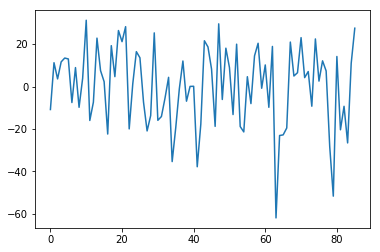

In [107]:
plt.plot(results.resid)

In [117]:
results.resid.sample(40).std()

17.30546430221837

In [110]:
results.resid.std()

18.807551040598735

In [118]:
results.resid.mean()

4.6433141569439106e-14

### Conclusion

By calculating the sample std we figure out that samles have almost the same variance, which is around population variance. That tells us that variance of datapoints is constant. Datapoints variance doesnt depend on the values of Xs.

The mean is equal to 0. So, residuals follow $N(0,\sigma)$

In [127]:
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(results.resid)
lzip(name, test)

[('Chi^2', 7.602436242961503), ('Two-tail probability', 0.022343538128788257)]

Another test with same conclusion

# Heteroskedasticity

In [90]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 3.6114028567110648),
 ('p-value', 0.16435912998095167),
 ('f-value', 1.819101474599113),
 ('f p-value', 0.16857736357589828)]

Datapoints are a heteroskedastic

# Linearity
Harvey-Collier multiplier test for Null hypothesis that the linear specification is correct:

In [122]:
name = ['t value', 'p value']
test = sms.linear_harvey_collier(results)
lzip(name, test)

[('t value', nan), ('p value', nan)]

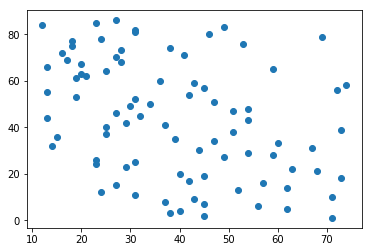

In [120]:
plt.scatter(dat.Literacy,dat.Lottery)